In [1]:
import pandas as pd
import numpy as np
import simulate
import matplotlib.pyplot as plt
import calculate_return as cr
import datetime as dt
import seaborn as sns
import matplotlib
import math
import sharpe
plt.style.use('seaborn')
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('figure', titlesize=13)  # fontsize of the figure title

#### Import data and prepare returns

In [2]:
df = pd.read_csv('shiller_data.txt', sep="\t", index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.index.date)
df['sp_return'] = (df['sp']+df['dividend']).pct_change().fillna(0)

### Loop over every 50 year period starting from january 1871 and calculate returns

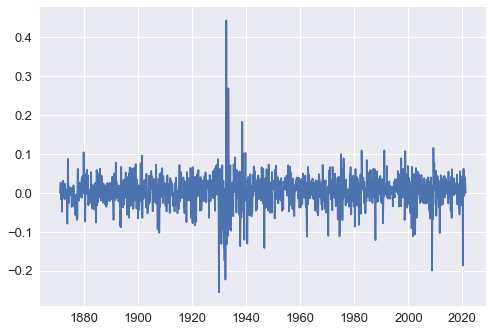

In [3]:
plt.plot(df['sp_return'])
#plt.yscale('log')

## Pi development

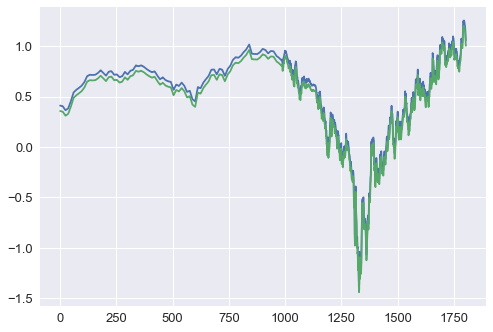

In [4]:
rf = df.loc[:, 'long_rf'].values/100
rm = rf +0.003
plt.plot(cr.calc_pi(2, 0.0278, 0.076, rf))
plt.plot(cr.calc_pi(2, 0.0278, 0.076, rm))

In [5]:
var = (df['sp']+df['dividend']).asfreq('Y', method='bfill').pct_change().var()
mr = (df['sp']+df['dividend']).asfreq('Y', method='bfill').pct_change().mean()

In [6]:
var

0.02873208113646254

In [20]:
rf.mean()

0.04515016629711751

In [21]:
cr.pi_arr(rf.mean(), 2, var, mr, 0.002)

0.2182255621925663

### 30-year pi development

In [7]:
roll_df = df.rolling(12*30).mean().dropna()
#roll_std = (df['sp_return']).rolling(12*30).var().dropna()
roll_var = ((df['sp']+df['dividend']).pct_change().rolling(12*30).std().dropna()*math.sqrt(12))**2
roll_sp_return = np.exp(roll_df['sp_return']*12)-1
roll_rf = roll_df['long_rf']/100
roll_rm = roll_rf.copy()+0.003

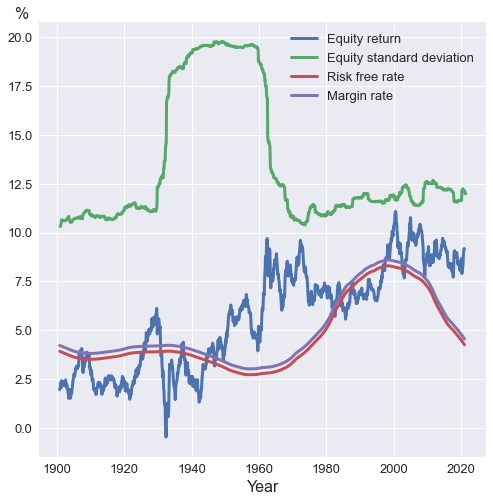

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(roll_sp_return*100, linewidth = 3)
ax.plot((roll_var**(0.5))*100, linewidth = 3)
ax.plot(roll_rf*100, linewidth = 3)
ax.plot(roll_rm*100, linewidth = 3)
#ax.legend(['Equity return', 'Equity standard deviation', 'Risk free rate', 'Margin rate'])
ax.legend(['Equity return', 'Equity standard deviation', 'Risk free rate', 'Margin rate'])
ax.set_xlabel('Year')
ax.set_ylabel('%', rotation=0, loc='top', labelpad=-21)
#fig.savefig('Empirical/rolling_development.png', bbox_inches = 'tight', pad_inches = 0.1)

### Resulting pi

Text(0, 1, '%')

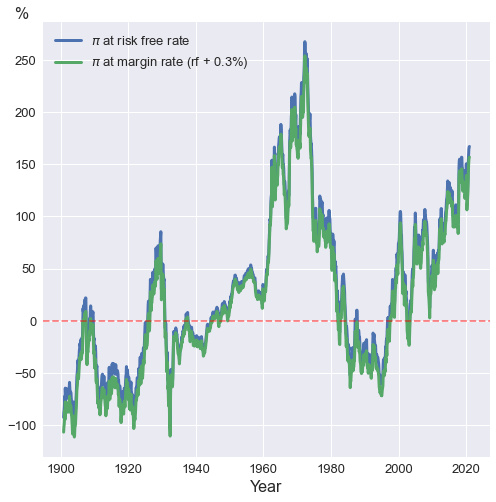

In [9]:
combined_rf = zip(roll_rf, roll_sp_return, roll_var)
pi_rf = [cr.pi_arr(rf, 2, std, ret, 0)*100 for rf, ret, std in combined_rf]

combined_rm = zip(roll_rm, roll_sp_return, roll_var)
pi_rm = [cr.pi_arr(rm, 2, std, ret, 0)*100 for rm, ret, std in combined_rm]

pies = pd.DataFrame([pi_rf, pi_rm]).transpose()
pies.index = pd.date_range('1900-12-01', '2020-12-01', freq='MS')
pies.columns = ['pi_rf', 'pi_rm']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(pies, linewidth = 3)
ax.axhline(0, c='red', alpha=.5, linestyle='--')
ax.legend(['$\pi$ at risk free rate', '$\pi$ at margin rate (rf + 0.3%)'])
ax.set_xlabel('Year')
ax.set_ylabel('%', rotation=0, loc='top', labelpad=-21)
#fig.savefig('Empirical/rolling_pi.png', bbox_inches = 'tight', pad_inches = 0.1)

### Using constant $\pi_{rf}$ and $\pi_{rm}$ to test strategy

In [10]:
const_pi_rf = sum(pi_rf)/len(pi_rf)
const_pi_rm = sum(pi_rm)/len(pi_rm)

In [11]:
print(const_pi_rf, const_pi_rm)

29.770405399324204 20.150993759550346


In [81]:
final_wealth = []

for year in range(1871, 1971):
#for year in range(1901, 1971):
    for month in range(1, 13):
        
        begin = dt.date(year, month, 1).strftime('%Y-%m-%d')
        end = dt.date(year+50, month, 1).strftime('%Y-%m-%d')
        
        returns = df.copy().loc[begin:end, 'sp_return'].values
        
        YEARLY_RF = df.long_rf.loc[begin:end].values/100
        YEARLY_RM = YEARLY_RF + 0.003
        
        pi_rm_shiller = np.full(601, const_pi_rm)
        pi_rf_shiller = np.full(601, const_pi_rf)
        
        shiller_return = cr.fetch_returns_shiller(returns=returns, YEARLY_RF=YEARLY_RF, YEARLY_RM=YEARLY_RF, YEARLY_INCOME_GROWTH=0.03, 
                                                 PI_RF = pi_rf_shiller, PI_RM = pi_rm_shiller)
        final_wealth.extend([shiller_return.loc[600, ['dual_phase', 'single_phase', '100', '9050']].values])
        #assert((returns == df.loc[begin:end, 'sp_return'].values).all)

In [82]:
shiller_results = pd.DataFrame(final_wealth, columns=['dual_phase', 'single_phase', '100', '9050'],
                              index = pd.date_range('1921-01-01', '2020-12-01', freq='MS'))
#cpi_norm = df.cpi/df.cpi.iloc[960]
#shiller_results = shiller_results.div(cpi_norm.loc['1951-01-01': '2020-12-01'], axis = 0)

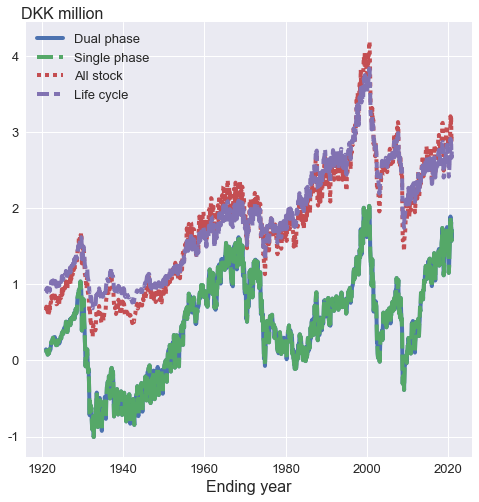

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.lineplot(data = shiller_results.loc[:,['dual_phase', 'single_phase', '100', '9050']]/1000000, linewidth = 4, linestyle="solid")      # Levered investments
ax.legend(['Dual phase', 'Single phase', 'All stock', 'Life cycle'])
ax.set_xlabel('Ending year')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('DKK million', rotation=0, loc='top', labelpad=-96)
fig.savefig('Empirical/shiller_result_constant_pi.png', bbox_inches = 'tight', pad_inches = 0.1)

### Using baseline $\pi_{rf}$ and $\pi_{rm}$ to test strategy

In [34]:
final_wealth = []

baseline_pi_rf = 0.987
baseline_pi_rm = 0.934

count = 0

for year in range(1871, 1971):
#for year in range(1901, 1971):
    for month in range(1, 13):
        begin = dt.date(year, month, 1).strftime('%Y-%m-%d')
        end = dt.date(year+50, month, 1).strftime('%Y-%m-%d')
        returns = df.copy().loc[begin:end, 'sp_return'].values
        #cpi = df.loc[begin:end, 'cpi']*100/df.loc[begin, 'cpi']
        #rf = roll_rf.copy().loc[begin]
        #std = roll_std.copy().loc[begin]
        #mr = roll_sp_return.copy().loc[begin]
        #YEARLY_RF = np.full(len(returns), rf)
        #YEARLY_RM = YEARLY_RF + 0.02
        YEARLY_RF = df.long_rf.copy().loc[begin:end].values/100
        YEARLY_RM = YEARLY_RF + 0.003
        
        #pi_rf_shiller = cr.calc_pi(2, std, mr, YEARLY_RF)
        #pi_rm_shiller = cr.calc_pi(2, std, mr, YEARLY_RF)
        pi_rm_shiller = np.full(601, baseline_pi_rf)
        pi_rf_shiller = np.full(601, baseline_pi_rm)
        
        shiller_return = cr.fetch_returns_shiller(returns=returns, YEARLY_RF=YEARLY_RF, YEARLY_RM=YEARLY_RF, YEARLY_INCOME_GROWTH=0.03, 
                                                  PI_RF = pi_rf_shiller, PI_RM = pi_rm_shiller)
        final_wealth.extend([shiller_return.loc[600, ['dual_phase', 'single_phase', '100', '9050']].values])

        #assert((returns == df.loc[begin:end, 'sp_return'].values).all)
        count += 1

In [94]:
shiller_results = pd.DataFrame(final_wealth, columns=['dual_phase', 'single_phase', '100', '9050'],
                              index = pd.date_range('1921-01-01', '2020-12-01', freq='MS'))
shiller_results['spread'] = shiller_results['dual_phase']-shiller_results['100']

Text(0, 1, 'DKK million')

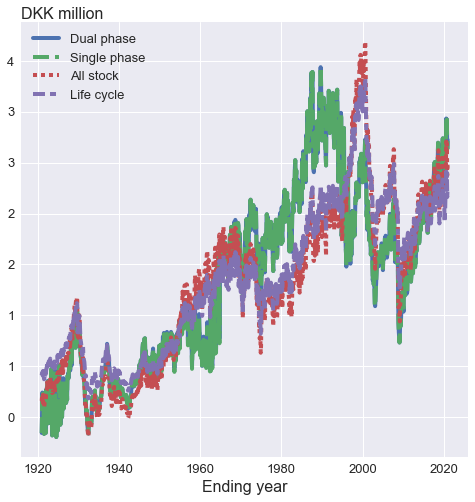

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.lineplot(data = shiller_results.loc[:,['dual_phase', 'single_phase', '100', '9050']]/1000000, linewidth = 4, linestyle="solid")      # Levered investments
ax.legend(['Dual phase', 'Single phase', 'All stock', 'Life cycle'])
ax.set_xlabel('Ending year')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('DKK million', rotation=0, loc='top', labelpad=-96)
#fig.savefig('Empirical/shiller_result_baseline_pi.png', bbox_inches = 'tight', pad_inches = 0.1)

### Historical Sharpe-ratios

In [12]:
#final_wealth = []
ports_shiller = []

baseline_pi_rf = 0.987
baseline_pi_rm = 0.934

count = 0

for year in range(1871, 1971):
#for year in range(1901, 1971):
    for month in range(1, 13):
        begin = dt.date(year, month, 1).strftime('%Y-%m-%d')
        end = dt.date(year+50, month, 1).strftime('%Y-%m-%d')
        returns = df.copy().loc[begin:end, 'sp_return'].values
        #cpi = df.loc[begin:end, 'cpi']*100/df.loc[begin, 'cpi']
        #rf = roll_rf.copy().loc[begin]
        #std = roll_std.copy().loc[begin]
        #mr = roll_sp_return.copy().loc[begin]
        #YEARLY_RF = np.full(len(returns), rf)
        #YEARLY_RM = YEARLY_RF + 0.02
        YEARLY_RF = df.long_rf.copy().loc[begin:end].values/100
        YEARLY_RM = YEARLY_RF + 0.003
        
        #pi_rf_shiller = cr.calc_pi(2, std, mr, YEARLY_RF)
        #pi_rm_shiller = cr.calc_pi(2, std, mr, YEARLY_RF)
        pi_rm_shiller = np.full(601, baseline_pi_rf)
        pi_rf_shiller = np.full(601, baseline_pi_rm)
        
        shiller_return = cr.fetch_returns_shiller(returns=returns, YEARLY_RF=YEARLY_RF, YEARLY_RM=YEARLY_RF, YEARLY_INCOME_GROWTH=0.03, 
                                                  PI_RF = pi_rf_shiller, PI_RM = pi_rm_shiller)
        shiller_return['random_state'] = count
        #final_wealth.extend([shiller_return.loc[600, ['dual_phase', 'single_phase', '100', '9050']].values])
        ports_shiller.append(shiller_return)
        #assert((returns == df.loc[begin:end, 'sp_return'].values).all)
        count += 1

ports_shiller = pd.concat(ports_shiller)
ports_shiller.set_index('random_state', drop = False, append=True, inplace = True)
ports_shiller = ports_shiller.reorder_levels(['random_state', 'period'])

<AxesSubplot:ylabel='Density'>

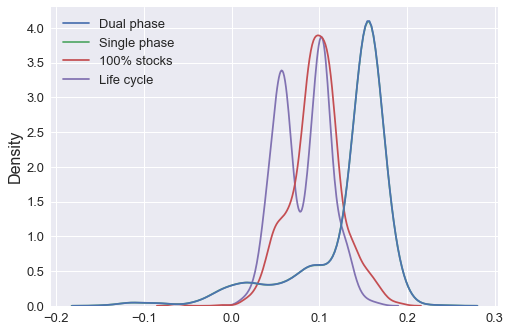

In [13]:
historical_sharpe = sharpe.calculate_sharpe(ports_shiller)
sns.kdeplot(data = historical_sharpe)

In [14]:
historical_sharpe.describe()

,Dual phase,Single phase,100% stocks,Life cycle
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.130496,0.130403,0.096177,0.082005
std,0.054777,0.054864,0.029990,0.029231
min,-0.142206,-0.142708,-0.063470,0.010590
25%,0.124973,0.124881,0.079950,0.056739
50%,0.151532,0.151236,0.097258,0.087322
75%,0.161220,0.161220,0.113210,0.104667
max,0.240365,0.240365,0.194126,0.168728


In [15]:
sharpe.CE_ports(ports_shiller, risk_premium = True)

,dual_phase,single_phase,100,9050
Certainty Equivalent,36.54407,36.727352,31.081939,18.689754


### Historical sharpe using historical pi_rf and pi_rm

In [29]:
const_pi_rf = sum(pi_rf)/len(pi_rf)
const_pi_rm = sum(pi_rm)/len(pi_rm)

ports_shiller = []

count = 0

for year in range(1871, 1971):
#for year in range(1901, 1971):
    for month in range(1, 13):
        
        begin = dt.date(year, month, 1).strftime('%Y-%m-%d')
        end = dt.date(year+50, month, 1).strftime('%Y-%m-%d')
        
        returns = df.copy().loc[begin:end, 'sp_return'].values
        
        YEARLY_RF = df.long_rf.loc[begin:end].values/100
        YEARLY_RM = YEARLY_RF + 0.003
        
        pi_rm_shiller = np.full(601, const_pi_rm)
        pi_rf_shiller = np.full(601, const_pi_rf)
        
        shiller_return = cr.fetch_returns_shiller(returns=returns, YEARLY_RF=YEARLY_RF, YEARLY_RM=YEARLY_RF, YEARLY_INCOME_GROWTH=0.03, 
                                                 PI_RF = pi_rf_shiller, PI_RM = pi_rm_shiller)
        shiller_return['random_state'] = count
        #final_wealth.extend([shiller_return.loc[600, ['dual_phase', 'single_phase', '100', '9050']].values])
        ports_shiller.append(shiller_return)
        #assert((returns == df.loc[begin:end, 'sp_return'].values).all)
        count += 1

ports_shiller = pd.concat(ports_shiller)
ports_shiller.set_index('random_state', drop = False, append=True, inplace = True)
ports_shiller = ports_shiller.reorder_levels(['random_state', 'period'])

<AxesSubplot:ylabel='Density'>

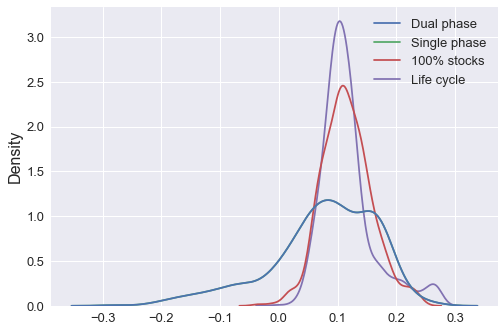

In [30]:
historical_sharpe = sharpe.calculate_sharpe(ports_shiller)
sns.kdeplot(data = historical_sharpe)

In [31]:
historical_sharpe.describe()

,Dual phase,Single phase,100% stocks,Life cycle
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.077301,0.077301,0.115198,0.116699
std,0.090959,0.090959,0.042626,0.045563
min,-0.286710,-0.286710,-0.036186,-0.005741
25%,0.033546,0.033546,0.086397,0.089589
50%,0.088688,0.088688,0.112928,0.108338
75%,0.149296,0.149296,0.141421,0.129397
max,0.271803,0.271803,0.245401,0.277578


In [32]:
sharpe.CE_ports(ports_shiller)

,dual_phase,single_phase,100,9050
Certainty Equivalent,"846,092.831726","846,092.831726","1,371,743.975760","1,552,483.195357"


Text(0, 1, 'DKK million')

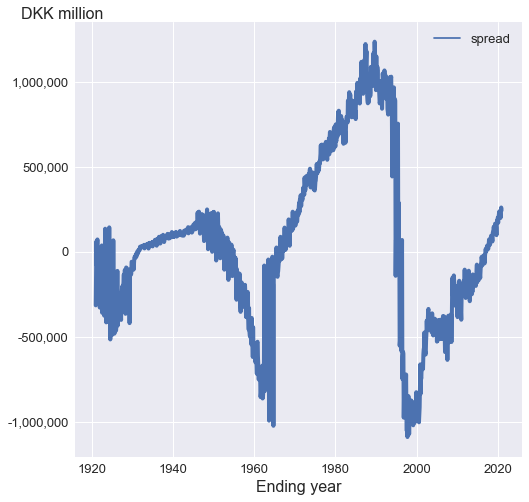

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
#sns.lineplot(data = shiller_results.loc[:,['dual_phase', 'single_phase', '100', '9050']]/1000000, linewidth = 4, linestyle="solid")      # Levered investments
sns.lineplot(data = shiller_results.loc[:,['spread']], linewidth = 4, linestyle="solid")      # Levered investments
#ax.legend(['Dual phase', 'Single phase', 'All stock', 'Life cycle'])
ax.set_xlabel('Ending year')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('DKK million', rotation=0, loc='top', labelpad=-96)

### Using rolling $\pi_{rf}$ and $\pi_{rm}$ to test strategy

In [88]:
final_wealth = []

#for year in range(1901, 1902):
for year in range(1901, 1971):
    for month in range(1, 13):
        begin = dt.date(year, month, 1).strftime('%Y-%m-%d')
        end = dt.date(year+50, month, 1).strftime('%Y-%m-%d')
        returns = df.copy().loc[begin:end, 'sp_return'].values
        #cpi = df.loc[begin:end, 'cpi']*100/df.loc[begin, 'cpi']
        #rf = roll_rf.copy().loc[begin]
        std = roll_var.copy().loc[begin]
        #mr = roll_sp_return.copy().loc[begin]
        #YEARLY_RF = np.full(len(returns), rf)
        #YEARLY_RM = YEARLY_RF + 0.02
        YEARLY_RF = roll_rf.copy().loc[begin:end].values
        YEARLY_RM = YEARLY_RF + 0.003

        pi_rf_shiller = max(0, cr.pi_arr(YEARLY_RF[0], 2, std, mr, 0.002))
        pi_rm_shiller = max(0, cr.pi_arr(YEARLY_RM[0], 2, std, mr, 0.002))
        
        pi_rf_shiller = np.full(601, pi_rf_shiller)
        pi_rm_shiller = np.full(601, pi_rm_shiller)
        
        
        shiller_return = cr.fetch_returns_shiller(returns=returns, YEARLY_RF=YEARLY_RF, YEARLY_RM=YEARLY_RF, YEARLY_INCOME_GROWTH=0.03, 
                                                  PI_RF = pi_rf_shiller, PI_RM = pi_rm_shiller)
        final_wealth.extend([shiller_return.loc[600, ['dual_phase', 'single_phase', '100', '9050']].values])
        #assert((returns == df.loc[begin:end, 'sp_return'].values).all)

In [89]:
shiller_results = pd.DataFrame(final_wealth, columns=['dual_phase', 'single_phase', '100', '9050'],
                              index = pd.date_range('1951-01-01', '2020-12-01', freq='MS'))
#cpi_norm = df.cpi/df.cpi.iloc[960]
#shiller_results = shiller_results.div(cpi_norm.loc['1951-01-01': '2020-12-01'], axis = 0)

Text(0, 1, 'DKK million')

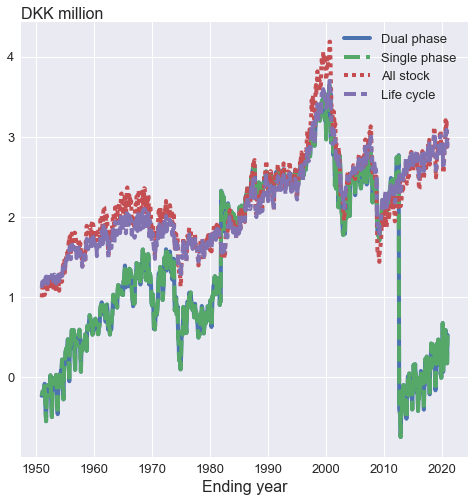

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.lineplot(data = shiller_results.loc[:,['dual_phase', 'single_phase', '100', '9050']]/1000000, linewidth = 4, linestyle="solid")      # Levered investments
ax.legend(['Dual phase', 'Single phase', 'All stock', 'Life cycle'])
ax.set_xlabel('Ending year')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('DKK million', rotation=0, loc='top', labelpad=-96)